In [1]:
from fastai.imports import *
from fastai.structured import *

from pandas_summary import DataFrameSummary
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from catboost import CatBoostRegressor, Pool, cv
import lightgbm as lgb
from IPython.display import display

from sklearn.model_selection import KFold
from sklearn import metrics
from datetime import datetime

import seaborn as sns

%matplotlib inline
pd.options.mode.chained_assignment = None
pd.set_option('display.float_format', lambda x: '%.3f' % x)
warnings.filterwarnings('ignore')
warnings.simplefilter(action='ignore', category=FutureWarning)

# sns.set(style='whitegrid', palette="deep", font_scale=1.1, rc={"figure.figsize": [12, 8]})
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 12, 8

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/lightgbm/__init__.py:46: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.3) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


### Custom Functions

In [2]:
def display_all(df):
    with pd.option_context("display.max_rows", 1000, "display.max_columns", 1000): 
        display(df)
        
def split_vals(a,n): return a[:n].copy(), a[n:].copy()

def get_stats(df,columns):
    fig, axs = plt.subplots(1,2)
    for column in columns:
        df2 = df[np.isfinite(df[column])]
        count, division = np.histogram(df2[column])
        null_value_stats = df[df[column].isnull()]
        print(f"Column name: {column}")
        print(f"Total Rows: {len(df)}")
        print(f"Positive values row count: {len(df[(df[column]>=0)])}")
        print(f"Negative values row count: {len(df[(df[column]<0)])}")
        print(f"Null values row count: {null_value_stats.shape[0]}")
        print(f"Column summary")
        print(df[column].describe())
        print(f"Cut: {division}")
        print(f"Count: {count}")
        df.boxplot(column=[column], ax=axs[0])
        df[column].plot.hist(bins=10, alpha=0.5, ax=axs[1])

def rmsle(real, predicted):
    sum=0.0
    for x in range(len(predicted)):
        if predicted[x]<0 or real[x]<0: #check for negative values
            continue
        p = np.log(predicted[x]+1)
        r = np.log(real[x]+1)
        sum = sum + (p - r)**2
    return round(100*(sum/len(predicted))**0.5,3)

def calc_smooth_mean(df, by, on, m):
    # Compute the global mean
    mean = df[on].mean()

    # Compute the number of values and the mean of each group
    agg = df.groupby(by)[on].agg(['count', 'mean'])
    counts = agg['count']
    means = agg['mean']

    # Compute the "smoothed" means
    smooth = (counts * means + m * mean) / (counts + m)

    # Replace each value by the according smoothed mean
    return smooth

def get_count_encode(train,test,by_cols,on_col,name):
    temp=train.groupby(by_cols)[on_col].count().reset_index().rename(columns={on_col:name})
    train=pd.merge(train,temp,how='left',on=by_cols)
    test=pd.merge(test,temp,how='left',on=by_cols)
    train[name].fillna(np.median(temp[name]),inplace=True)
    test[name].fillna(np.median(temp[name]),inplace=True)
    return train,test

def get_mean_encode(train,test,by_cols,on_col,name):
    temp=train.groupby(by_cols)[on_col].mean().reset_index().rename(columns={on_col:name})
    train=pd.merge(train,temp,how='left',on=by_cols)
    test=pd.merge(test,temp,how='left',on=by_cols)
    train[name].fillna(np.median(temp[name]),inplace=True)
    test[name].fillna(np.median(temp[name]),inplace=True)
    return train,test

def remove_outliers(df, column):
    print(f'Original dataframe has {df.shape[0]} records')
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    low_fence = (Q1 - 1.5 * IQR)
    high_fence = (Q3 + 1.5 * IQR)
    df_out = df.loc[(df[column] > low_fence) & (df[column] < high_fence)]
    print(f'Processed dataframe has {df_out.shape[0]} records')
    print(f'Records discarded: {df.shape[0] - df_out.shape[0]}')
        
    return df_out

In [3]:
train_data = pd.read_csv('./data/food_forecasting/train_files/train.csv')

In [4]:
test_data = pd.read_csv('./data/food_forecasting/test.csv')

In [5]:
meal_data = pd.read_csv('./data/food_forecasting/train_files/meal_info.csv')

In [6]:
store_data = pd.read_csv('./data/food_forecasting/train_files/fulfilment_center_info.csv')

In [7]:
train_data  = pd.merge(train_data, meal_data, how="left",on='meal_id')

In [8]:
full_train  = pd.merge(train_data, store_data, how="left",on='center_id')

In [9]:
test_data  = pd.merge(test_data, meal_data, how="left",on='meal_id')

In [10]:
full_test  = pd.merge(test_data, store_data, how="left",on='center_id')
full_test['num_orders'] = np.nan

In [11]:
display_all(full_train.head())

,id,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured,num_orders,category,cuisine,city_code,region_code,center_type,op_area
0,1379560,1,55,1885,136.830,152.290,0,0,177,Beverages,Thai,647,56,TYPE_C,2.000
1,1466964,1,55,1993,136.830,135.830,0,0,270,Beverages,Thai,647,56,TYPE_C,2.000
2,1346989,1,55,2539,134.860,135.860,0,0,189,Beverages,Thai,647,56,TYPE_C,2.000
3,1338232,1,55,2139,339.500,437.530,0,0,54,Beverages,Indian,647,56,TYPE_C,2.000
4,1448490,1,55,2631,243.500,242.500,0,0,40,Beverages,Indian,647,56,TYPE_C,2.000


In [12]:
full_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 456548 entries, 0 to 456547
Data columns (total 15 columns):
id                       456548 non-null int64
week                     456548 non-null int64
center_id                456548 non-null int64
meal_id                  456548 non-null int64
checkout_price           456548 non-null float64
base_price               456548 non-null float64
emailer_for_promotion    456548 non-null int64
homepage_featured        456548 non-null int64
num_orders               456548 non-null int64
category                 456548 non-null object
cuisine                  456548 non-null object
city_code                456548 non-null int64
region_code              456548 non-null int64
center_type              456548 non-null object
op_area                  456548 non-null float64
dtypes: float64(3), int64(9), object(3)
memory usage: 55.7+ MB


In [13]:
full_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 32573 entries, 0 to 32572
Data columns (total 15 columns):
id                       32573 non-null int64
week                     32573 non-null int64
center_id                32573 non-null int64
meal_id                  32573 non-null int64
checkout_price           32573 non-null float64
base_price               32573 non-null float64
emailer_for_promotion    32573 non-null int64
homepage_featured        32573 non-null int64
category                 32573 non-null object
cuisine                  32573 non-null object
city_code                32573 non-null int64
region_code              32573 non-null int64
center_type              32573 non-null object
op_area                  32573 non-null float64
num_orders               0 non-null float64
dtypes: float64(4), int64(8), object(3)
memory usage: 4.0+ MB


In [14]:
full_train.describe()

,id,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured,num_orders,city_code,region_code,op_area
count,456548.000,456548.000,456548.000,456548.000,456548.000,456548.000,456548.000,456548.000,456548.000,456548.000,456548.000,456548.000
mean,1250096.306,74.769,82.106,2024.337,332.239,354.157,0.081,0.109,261.873,601.553,56.615,4.084
std,144354.822,41.525,45.975,547.421,152.940,160.716,0.273,0.312,395.923,66.196,17.641,1.092
min,1000000.000,1.000,10.000,1062.000,2.970,55.350,0.000,0.000,13.000,456.000,23.000,0.900
25%,1124998.750,39.000,43.000,1558.000,228.950,243.500,0.000,0.000,54.000,553.000,34.000,3.600
50%,1250183.500,76.000,76.000,1993.000,296.820,310.460,0.000,0.000,136.000,596.000,56.000,4.000
75%,1375140.250,111.000,110.000,2539.000,445.230,458.870,0.000,0.000,324.000,651.000,77.000,4.500
max,1499999.000,145.000,186.000,2956.000,866.270,866.270,1.000,1.000,24299.000,713.000,93.000,7.000


In [15]:
numerical = full_train._get_numeric_data().columns.tolist()
categorical = ['category', 'cuisine', 'center_type']

### Exploratory Data Analysis

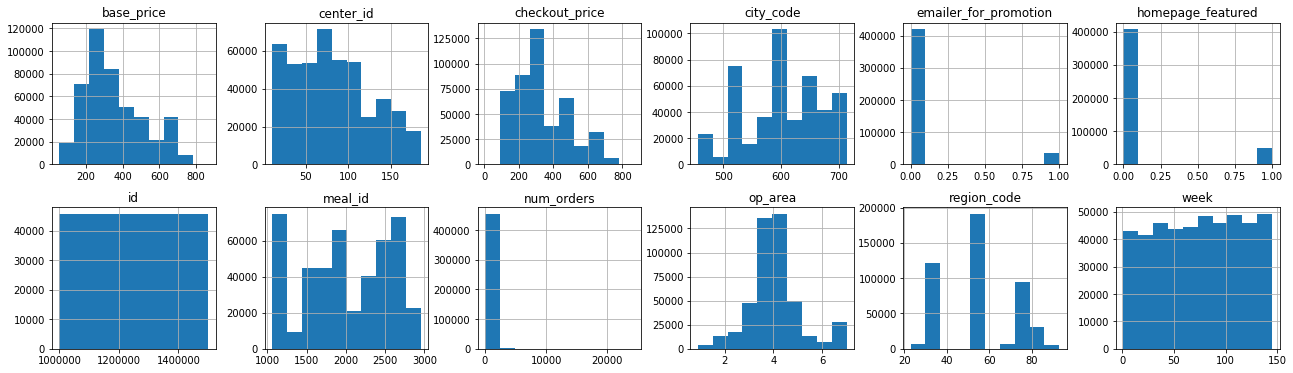

In [16]:
full_train[numerical].hist( figsize=(22, 6), layout=(2, 6));

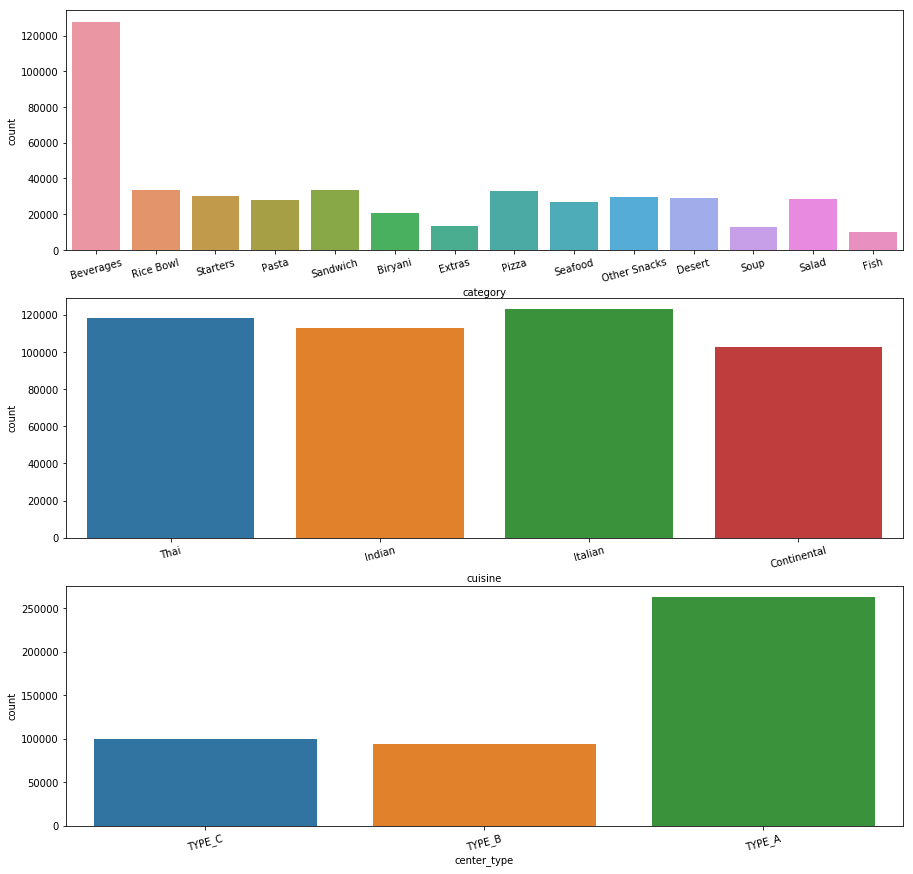

In [17]:
fig, ax = plt.subplots(3, 1, figsize=(15, 15))
for variable, subplot in zip(categorical, ax.flatten()):
    sns.countplot(full_train[variable], ax=subplot)
    for label in subplot.get_xticklabels():
        label.set_rotation(15)

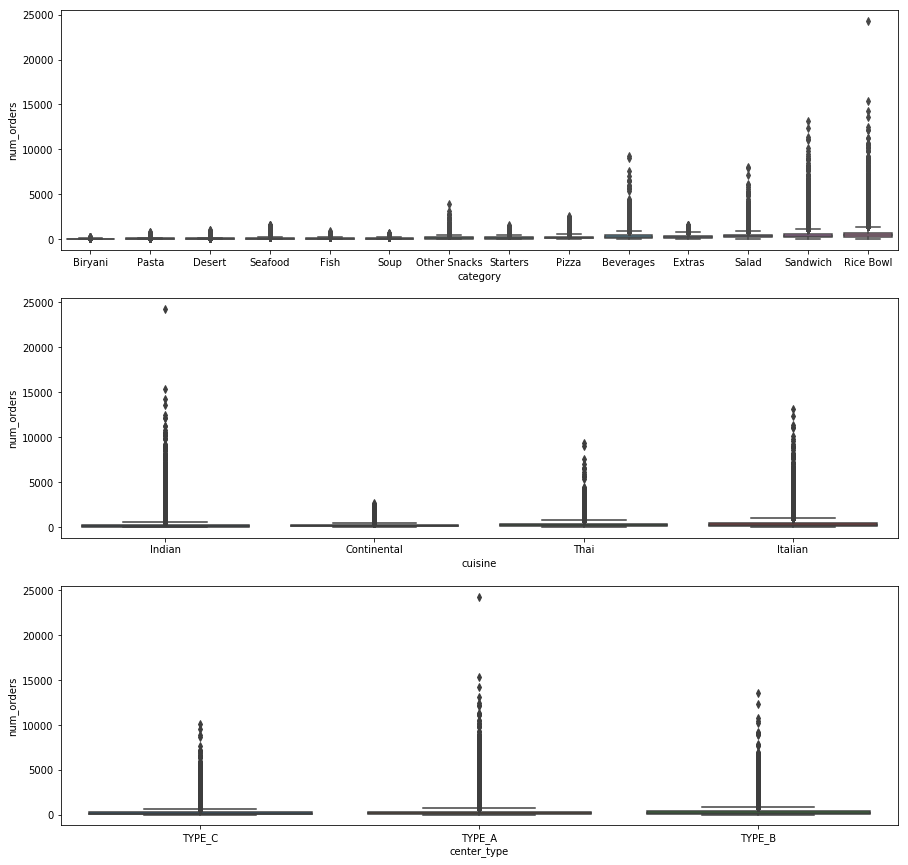

In [18]:
fig, ax = plt.subplots(3, 1, figsize=(15, 15))
for var, subplot in zip(categorical, ax.flatten()):
    sorted_vals = full_train.groupby([var])['num_orders'].median().sort_values()
    sns.boxplot(x=var, y='num_orders', data=full_train, ax=subplot, order=list(sorted_vals.index))

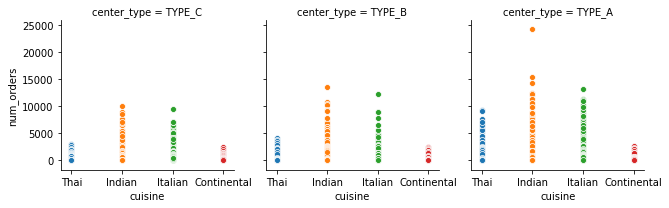

In [19]:
cond_plot = sns.FacetGrid(data=full_train, col='center_type', hue='cuisine', col_wrap=4)
cond_plot.map(sns.scatterplot, 'cuisine', 'num_orders');

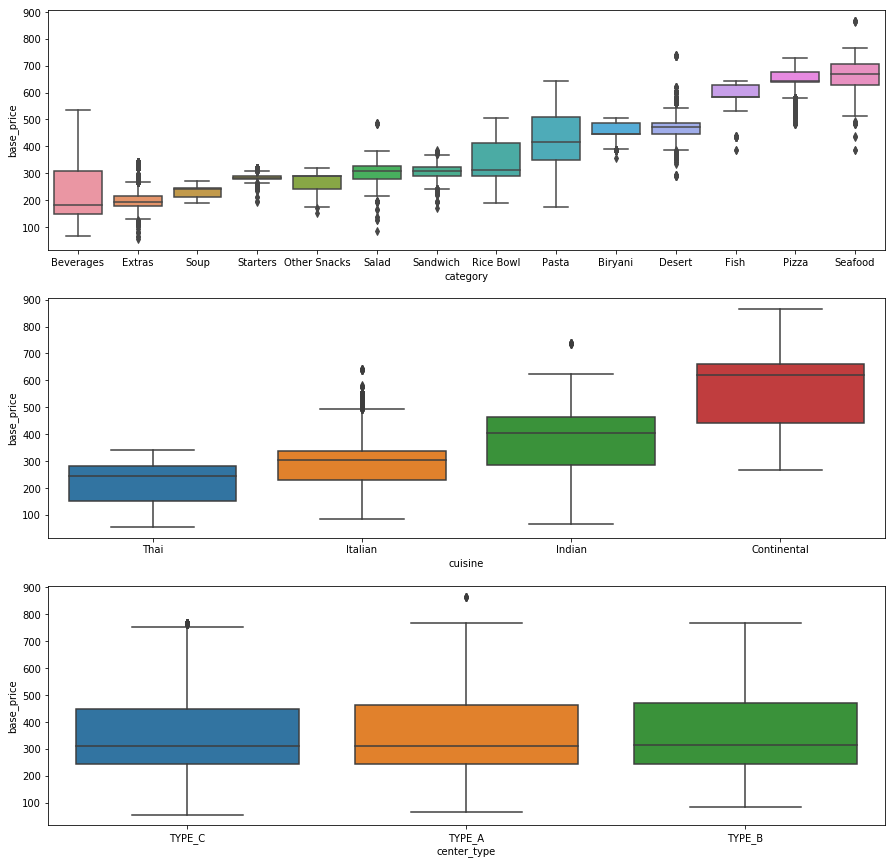

In [20]:
fig, ax = plt.subplots(3, 1, figsize=(15, 15))
for var, subplot in zip(categorical, ax.flatten()):
    sorted_vals = full_train.groupby([var])['base_price'].median().sort_values()
    sns.boxplot(x=var, y='base_price', data=full_train, ax=subplot, order=list(sorted_vals.index))

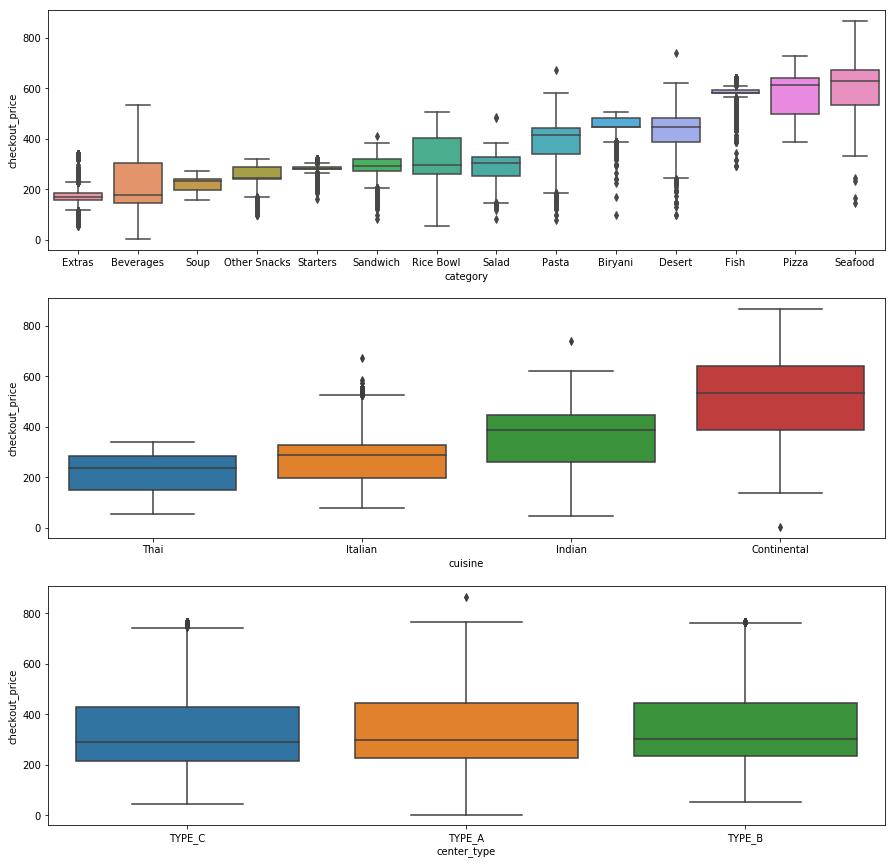

In [21]:
fig, ax = plt.subplots(3, 1, figsize=(15, 15))
for var, subplot in zip(categorical, ax.flatten()):
    sorted_vals = full_train.groupby([var])['checkout_price'].median().sort_values()
    sns.boxplot(x=var, y='checkout_price', data=full_train, ax=subplot, order=list(sorted_vals.index))

In [22]:
# sns.jointplot(x=full_train['base_price'], y=full_train['num_orders']);

In [23]:
# sns.jointplot(x=full_train['checkout_price'], y=full_train['num_orders']);

In [24]:
# sns.jointplot(x=full_train['checkout_price'], y=full_train['base_price']);

In [25]:
# sns.jointplot(x=full_train['op_area'], y=full_train['num_orders']);

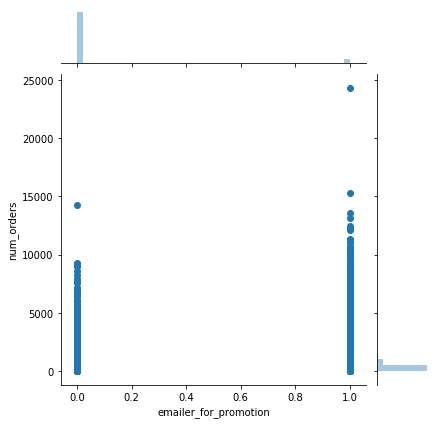

In [26]:
sns.jointplot(x=full_train['emailer_for_promotion'], y=full_train['num_orders']);

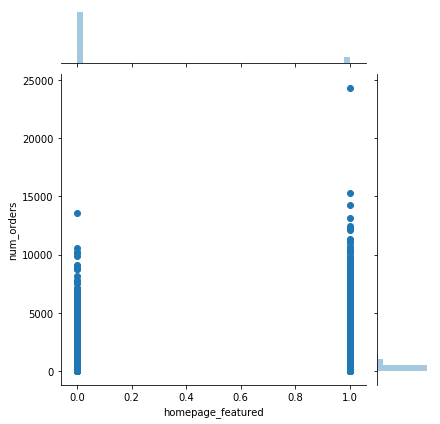

In [27]:
sns.jointplot(x=full_train['homepage_featured'], y=full_train['num_orders']);

In [28]:
display_all(full_train.isnull().sum().sort_index()/len(full_train))

base_price              0.000
category                0.000
center_id               0.000
center_type             0.000
checkout_price          0.000
city_code               0.000
cuisine                 0.000
emailer_for_promotion   0.000
homepage_featured       0.000
id                      0.000
meal_id                 0.000
num_orders              0.000
op_area                 0.000
region_code             0.000
week                    0.000
dtype: float64

### Feature Engineering

In [29]:
full_data = full_train.append(full_test)

In [30]:
display_all(full_data.tail())

,base_price,category,center_id,center_type,checkout_price,city_code,cuisine,emailer_for_promotion,homepage_featured,id,meal_id,num_orders,op_area,region_code,week
32568,484.090,Desert,61,TYPE_A,482.090,473,Indian,0,0,1250239,1543,nan,4.500,77,155
32569,483.090,Desert,61,TYPE_A,483.090,473,Indian,0,0,1039516,2304,nan,4.500,77,155
32570,323.070,Salad,61,TYPE_A,322.070,473,Italian,0,0,1158107,2664,nan,4.500,77,155
32571,323.070,Salad,61,TYPE_A,322.070,473,Italian,0,0,1444235,2569,nan,4.500,77,155
32572,276.450,Salad,61,TYPE_A,276.450,473,Italian,0,0,1291286,2490,nan,4.500,77,155


In [31]:
full_data['discount_avail'] = np.where(full_data['checkout_price'] > full_data['base_price']
                                      ,'no'
                                      ,np.where(full_data['base_price'] > full_data['checkout_price']
                                               ,'yes'
                                               ,'same')
                                      )

In [32]:
full_data['discount_rate'] = np.where(full_data['base_price'] > full_data['checkout_price']
                                      ,round(100*(full_data['base_price'] - full_data['checkout_price'])
                                             /full_data['base_price'],2)
                                      ,0
                                      )

In [33]:
full_data['surcharge'] = np.where(full_data['checkout_price'] > full_data['base_price']
                                      ,round(100*(full_data['checkout_price'] - full_data['base_price'])
                                             /full_data['checkout_price'],2)
                                      ,0
                                      )

In [34]:
full_data['price_diff'] = full_data['checkout_price'] - full_data['base_price']

In [35]:
full_data['promo_combo'] = full_data['emailer_for_promotion'] + full_data['homepage_featured']

In [36]:
full_data['op_area_disc'] = full_data['discount_rate']*full_data['op_area']

In [37]:
full_data['op_area_surch'] = full_data['surcharge']*full_data['op_area']

In [38]:
full_data['op_area_promo'] = full_data['promo_combo']*full_data['op_area']

In [39]:
train_df = full_data[:len(train_data)]

In [40]:
test_df = full_data[len(train_data):]

In [41]:
train_df['week_num']=train_df.week%52
test_df['week_num']=test_df.week%52

train_df['week_num'] = np.where(train_df['week_num'] == 0 ,52, train_df['week_num'])
test_df['week_num'] = np.where(test_df['week_num'] == 0 ,52, test_df['week_num'])

In [42]:
train_df['month_num']=np.ceil(train_df.week_num/4).astype('int')
test_df['month_num']=np.ceil(test_df.week_num/4).astype('int')

In [43]:
train_df['quarter_num']=np.ceil(train_df.week_num/13).astype('int')
test_df['quarter_num']=np.ceil(test_df.week_num/13).astype('int')

In [44]:
center_meal_df = calc_smooth_mean(train_df, ['center_id', 'meal_id'], 'num_orders', 300).reset_index()
center_meal_df.rename(index=str,columns={0:'cen_meal_orders'}, inplace=True)

In [45]:
week_orders = calc_smooth_mean(train_df, ['week_num'], 'num_orders', 300).reset_index()
week_orders.rename(index=str,columns={0:'week_orders'}, inplace=True)

In [46]:
month_orders = calc_smooth_mean(train_df, ['month_num'], 'num_orders', 300).reset_index()
month_orders.rename(index=str,columns={0:'month_orders'}, inplace=True)

In [47]:
quarter_orders = calc_smooth_mean(train_df, ['quarter_num'], 'num_orders', 300).reset_index()
quarter_orders.rename(index=str,columns={0:'quarter_orders'}, inplace=True)

In [48]:
center_category_df = calc_smooth_mean(train_df, ['center_id', 'category'], 'num_orders', 300).reset_index()
center_category_df.rename(index=str,columns={0:'cen_cat_orders'}, inplace=True)

In [49]:
center_cuisine_df = calc_smooth_mean(train_df, ['center_id', 'cuisine'], 'num_orders', 300).reset_index()
center_cuisine_df.rename(index=str,columns={0:'cen_cus_orders'}, inplace=True)

In [50]:
promo_disc_df = calc_smooth_mean(train_df, ['promo_combo'
                                            , 'discount_avail'
                                            , 'category'
                                           ], 'num_orders', 300).reset_index()
promo_disc_df.rename(index=str,columns={0:'promo_disc_orders'}, inplace=True)

In [51]:
city_reg_cent_df = calc_smooth_mean(train_df, ['city_code'
                                              , 'region_code'
                                              , 'center_type'
                                              ], 'num_orders', 300).reset_index()
city_reg_cent_df.rename(index=str,columns={0:'city_reg_cent_orders'}, inplace=True)

In [52]:
centype_cat_cus_df = calc_smooth_mean(train_df, ['center_type'
                                                , 'category'
                                                , 'cuisine'
                                                ], 'num_orders', 300).reset_index()
centype_cat_cus_df.rename(index=str,columns={0:'centype_cat_cus_orders'}, inplace=True)

In [53]:
train_df  = pd.merge(train_df, center_category_df, how="left", on=['center_id', 'category'])
train_df  = pd.merge(train_df, center_meal_df, how="left", on=['center_id', 'meal_id'])
train_df  = pd.merge(train_df, center_cuisine_df, how="left", on=['center_id', 'cuisine'])
train_df  = pd.merge(train_df, promo_disc_df, how="left", on=['promo_combo', 'discount_avail' ,'category'])
train_df  = pd.merge(train_df, city_reg_cent_df, how="left", on=['city_code', 'region_code' ,'center_type'])
train_df  = pd.merge(train_df, centype_cat_cus_df, how="left", on=['center_type', 'category' ,'cuisine'])
train_df  = pd.merge(train_df, week_orders, how="left", on=['week_num'])
train_df  = pd.merge(train_df, month_orders, how="left", on=['month_num'])
train_df  = pd.merge(train_df, quarter_orders, how="left", on=['quarter_num'])

In [54]:
test_df  = pd.merge(test_df, center_category_df, how="left", on=['center_id', 'category'])
test_df  = pd.merge(test_df, center_meal_df, how="left", on=['center_id', 'meal_id'])
test_df  = pd.merge(test_df, center_cuisine_df, how="left", on=['center_id', 'cuisine'])
test_df  = pd.merge(test_df, promo_disc_df, how="left", on=['promo_combo', 'discount_avail','category'])
test_df  = pd.merge(test_df, city_reg_cent_df, how="left", on=['city_code', 'region_code' ,'center_type'])
test_df  = pd.merge(test_df, centype_cat_cus_df, how="left", on=['center_type', 'category' ,'cuisine'])
test_df  = pd.merge(test_df, week_orders, how="left", on=['week_num'])
test_df  = pd.merge(test_df, month_orders, how="left", on=['month_num'])
test_df  = pd.merge(test_df, quarter_orders, how="left", on=['quarter_num'])

In [55]:
train_df, test_df = get_count_encode(train_df,test_df,['week_num','center_id'],'id','count_week_center')
train_df, test_df = get_count_encode(train_df,test_df,['week_num','meal_id'],'id','count_week_meal')

In [56]:
unwanted_cols = [
                   'city_code'
                 , 'op_area'
                 , 'week_num'
                 , 'month_num'
                 , 'quarter_num'
                 , 'cuisine'
                 , 'center_type'
                 , 'region_code'
                 , 'op_area_surch'
                 , 'surcharge'
                 , 'discount_avail'
                ]

In [57]:
train_df.drop(unwanted_cols, axis=1, inplace=True)
test_df.drop(unwanted_cols, axis=1, inplace=True)

In [58]:
train_df.shape, train_data.shape, test_df.shape, test_data.shape

((456548, 26), (456548, 11), (32573, 26), (32573, 10))

In [59]:
display_all(100*train_df.isnull().sum().sort_index()/len(train_df))

base_price               0.000
category                 0.000
cen_cat_orders           0.000
cen_cus_orders           0.000
cen_meal_orders          0.000
center_id                0.000
centype_cat_cus_orders   0.000
checkout_price           0.000
city_reg_cent_orders     0.000
count_week_center        0.000
count_week_meal          0.000
discount_rate            0.000
emailer_for_promotion    0.000
homepage_featured        0.000
id                       0.000
meal_id                  0.000
month_orders             0.000
num_orders               0.000
op_area_disc             0.000
op_area_promo            0.000
price_diff               0.000
promo_combo              0.000
promo_disc_orders        0.000
quarter_orders           0.000
week                     0.000
week_orders              0.000
dtype: float64

In [60]:
display_all(100*test_df.isnull().sum().sort_index()/len(test_df))

base_price                 0.000
category                   0.000
cen_cat_orders             0.040
cen_cus_orders             0.000
cen_meal_orders            0.040
center_id                  0.000
centype_cat_cus_orders     0.000
checkout_price             0.000
city_reg_cent_orders       0.000
count_week_center          0.000
count_week_meal            0.000
discount_rate              0.000
emailer_for_promotion      0.000
homepage_featured          0.000
id                         0.000
meal_id                    0.000
month_orders               0.000
num_orders               100.000
op_area_disc               0.000
op_area_promo              0.000
price_diff                 0.000
promo_combo                0.000
promo_disc_orders          0.000
quarter_orders             0.000
week                       0.000
week_orders                0.000
dtype: float64

In [61]:
Train = train_df.copy(deep=True)
Test = test_df.copy(deep=True)

In [62]:
train_cats(train_df)

In [63]:
apply_cats(test_df, train_df)

In [64]:
df, y, nas = proc_df(train_df, 'num_orders', skip_flds=['id'])
df_test, _, nas = proc_df(test_df, 'num_orders', skip_flds=['id'])

In [65]:
display_all(df.head())

,base_price,category,center_id,checkout_price,emailer_for_promotion,homepage_featured,meal_id,week,discount_rate,price_diff,promo_combo,op_area_disc,op_area_promo,cen_cat_orders,cen_meal_orders,cen_cus_orders,promo_disc_orders,city_reg_cent_orders,centype_cat_cus_orders,week_orders,month_orders,quarter_orders,count_week_center,count_week_meal
0,152.290,1,55,136.830,0,0,1885,1,10.150,-15.460,0,20.300,0.000,191.066,251.593,151.683,275.620,168.896,280.842,293.932,268.299,270.753,112,230
1,135.830,1,55,136.830,0,0,1993,1,0.000,1.000,0,0.000,0.000,191.066,257.018,151.683,263.080,168.896,280.842,293.932,268.299,270.753,112,231
2,135.860,1,55,134.860,0,0,2539,1,0.740,-1.000,0,1.480,0.000,191.066,238.743,151.683,275.620,168.896,280.842,293.932,268.299,270.753,112,216
3,437.530,1,55,339.500,0,0,2139,1,22.410,-98.030,0,44.820,0.000,191.066,201.404,174.910,275.620,168.896,76.711,293.932,268.299,270.753,112,189
4,242.500,1,55,243.500,0,0,2631,1,0.000,1.000,0,0.000,0.000,191.066,199.843,174.910,263.080,168.896,76.711,293.932,268.299,270.753,112,219


In [66]:
display_all(df_test.head())

,base_price,category,center_id,checkout_price,emailer_for_promotion,homepage_featured,meal_id,week,discount_rate,price_diff,promo_combo,op_area_disc,op_area_promo,cen_cat_orders,cen_meal_orders,cen_cus_orders,promo_disc_orders,city_reg_cent_orders,centype_cat_cus_orders,week_orders,month_orders,quarter_orders,count_week_center,count_week_meal
0,159.110,1,55,158.110,0,0,1885,146,0.630,-1.000,0,1.260,0.000,191.066,251.593,151.683,275.620,168.896,280.842,249.385,245.385,267.665,70,153
1,159.110,1,55,160.110,0,0,1993,146,0.000,1.000,0,0.000,0.000,191.066,257.018,151.683,263.080,168.896,280.842,249.385,245.385,267.665,70,153
2,159.140,1,55,157.140,0,0,2539,146,1.260,-2.000,0,2.520,0.000,191.066,238.743,151.683,275.620,168.896,280.842,249.385,245.385,267.665,70,138
3,162.020,1,55,162.020,0,0,2631,146,0.000,0.000,0,0.000,0.000,191.066,199.843,174.910,261.925,168.896,76.711,249.385,245.385,267.665,70,147
4,163.930,1,55,163.930,0,0,1248,146,0.000,0.000,0,0.000,0.000,191.066,198.316,174.910,261.925,168.896,76.711,249.385,245.385,267.665,70,137


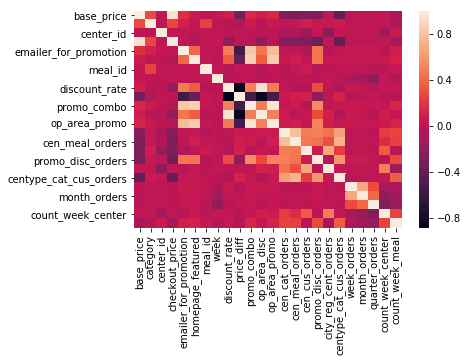

In [67]:
sns.heatmap(df.corr())

In [68]:
n_valid = 32573  # same as test set size
n_trn = len(df)-n_valid
X_train, X_valid = split_vals(df, n_trn)
y_train, y_valid = split_vals(y, n_trn)

X_train.shape, y_train.shape, X_valid.shape

((423975, 24), (423975,), (32573, 24))

In [69]:
def print_score(m):
    res = [rmsle(m.predict(X_train), y_train), rmsle(m.predict(X_valid), y_valid),
                round(m.score(X_train, y_train),3), round(m.score(X_valid, y_valid),3)]
    if hasattr(m, 'oob_score_'): res.append(round(m.oob_score_,3))
    print(res)

### Model Building

In [70]:
rf = RandomForestRegressor(n_estimators=100, n_jobs=-1, oob_score=True)
%time rf.fit(X_train, y_train)
print_score(rf)

CPU times: user 13min 52s, sys: 5.53 s, total: 13min 58s
Wall time: 2min
[21.771, 53.535, 0.984, 0.814, 0.885]


### Random Forest Model

In [71]:
rf = RandomForestRegressor(n_estimators=750, min_samples_leaf=6, max_features=0.5, n_jobs=-1, oob_score=True)
%time rf.fit(X_train, y_train)
print_score(rf)

CPU times: user 52min 57s, sys: 35 s, total: 53min 32s
Wall time: 11min 36s
[37.71, 50.616, 0.931, 0.847, 0.883]


In [72]:
sorted(zip(rf.feature_importances_,X_train),reverse=True)

[(0.41077251764108236, 'cen_meal_orders'),
 (0.15616933535465077, 'promo_disc_orders'),
 (0.060799840495610144, 'centype_cat_cus_orders'),
 (0.053950100301705994, 'cen_cat_orders'),
 (0.05097869689274045, 'op_area_promo'),
 (0.04041078330906157, 'discount_rate'),
 (0.0380827175080328, 'checkout_price'),
 (0.024522488883963082, 'promo_combo'),
 (0.02308937801710445, 'op_area_disc'),
 (0.021944827129869244, 'week'),
 (0.01599410993224498, 'emailer_for_promotion'),
 (0.014689152352348004, 'week_orders'),
 (0.014003531137741575, 'price_diff'),
 (0.012012175118147094, 'base_price'),
 (0.010972339747717979, 'cen_cus_orders'),
 (0.009020646621290096, 'count_week_center'),
 (0.008575042340889615, 'count_week_meal'),
 (0.0074113369849423735, 'city_reg_cent_orders'),
 (0.006377668121181707, 'meal_id'),
 (0.0050746753748173844, 'month_orders'),
 (0.004119855889474235, 'homepage_featured'),
 (0.0041001412429854224, 'category'),
 (0.0038107151056173513, 'center_id'),
 (0.003117924496781947, 'quarte

In [ ]:
err=[]
y_pred_all=[]
fold=KFold(n_splits=5, shuffle=True, random_state=1994)
for train_idx, test_idx in fold.split(df, y):
    X_train, X_test = df.iloc[train_idx], df.iloc[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]
    model = RandomForestRegressor(n_estimators=1000
                               , min_samples_leaf=6
                               , max_features=0.5
                               , n_jobs=-1
                               , oob_score=True
                               , verbose=1
                              )
    model.fit(X_train,y_train)
    preds=model.predict(X_test)
    print("rmsle: ",rmsle(preds, y_test))
    err.append(rmsle(preds, y_test))
    p = model.predict(df_test)
    y_pred_all.append(p)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   26.7s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  7.4min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed: 15.0min
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed: 19.9min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.4s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    2.4s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    6.1s
[Parallel(n_jobs=8)]: Done 784 tasks      | elapsed:   11.5s
[Parallel(n_jobs=8)]: Done 1000 out of 1000 | elapsed:   15.0s finished


rmsle:  47.38


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.8s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    2.0s
[Parallel(n_jobs=8)]: Done 784 tasks      | elapsed:    3.5s
[Parallel(n_jobs=8)]: Done 1000 out of 1000 | elapsed:    4.4s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   51.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  3.8min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  7.6min


In [ ]:
print(np.mean(err,0))

In [ ]:
y_pred_all

In [ ]:
submission=pd.DataFrame({'id':full_test['id']
                         ,'num_orders':np.mean(y_pred_all,0)
                        })
submission['num_orders'] = np.floor(submission['num_orders'])
submission.head()

In [ ]:
file_timestamp = datetime.now().strftime('%m%d%Y_%H%M')
submission.to_csv(f'./data/food_forecasting/Submission_{file_timestamp}.csv', index=False)

### LightGBM Model

In [78]:
# err_lgb=[]
# y_pred_tot_lgb=[]
# fold=KFold(n_splits=5, shuffle=True, random_state=1994)
# for train_idx, test_idx in fold.split(df, y):
#     X_train, X_test = df.iloc[train_idx], df.iloc[test_idx]
#     y_train, y_test = y[train_idx], y[test_idx]
#     params = {
#         "objective" : "regression",
#         "metric" : "rmse",
#         "boosting": "gbdt",
#         "num_leaves" : 100,
#         "max_depth" : 25,
#         "min_child_weight" : 50,
#         "learning_rate" : 0.05,
#         "bagging_fraction" : 0.7,
#         "feature_fraction" : 0.9,
#         "bagging_frequency" : 5,
#         "bagging_seed" : 7979,
#         "verbosity" : -1
#     }
#     lgtrain = lgb.Dataset(X_train, y_train)
#     lgval = lgb.Dataset(X_test, y_test)
#     evals_result = {}
#     model = lgb.train(params
#                       , lgtrain
#                       , 3000
#                       , valid_sets=[lgval]
#                       , early_stopping_rounds=100
#                       , verbose_eval=100
#                       , evals_result=evals_result
#                      )
#     preds=model.predict(X_test, num_iteration=model.best_iteration)
#     preds[preds < 0] = 0
#     print("rmsle: ",rmsle(preds, y_test))
#     err_lgb.append(rmsle(preds, y_test))
#     p = model.predict(df_test, num_iteration=model.best_iteration)
#     p[p < 0] = 0
#     y_pred_tot_lgb.append(p)

In [79]:
# fig, ax = plt.subplots(figsize=(12,10))
# lgb.plot_importance(model, max_num_features=50, height=0.8, ax=ax)
# ax.grid(False)
# plt.title("LightGBM - Feature Importance", fontsize=15)
# plt.show()

In [80]:
# print(np.mean(err_lgb,0))

In [81]:
# y_pred_tot_lgb

In [82]:
# submission=pd.DataFrame({'id':full_test['id']
#                          ,'num_orders':np.mean(y_pred_tot_lgb,0)
#                         })
# submission['num_orders'] = np.floor(submission['num_orders'])
# submission.head()

In [83]:
# file_timestamp = datetime.now().strftime('%m%d%Y_%H%M')
# submission.to_csv(f'./data/food_forecasting/Submission_{file_timestamp}.csv', index=False)

### Useful functions

In [84]:
# import xgboost as xgb
# from xgboost import plot_importance
# import lightgbm as lgbm

In [85]:
# dtrain = xgb.DMatrix(df, label=y)

In [86]:
# def train_xgb(max_depth=6,num_round=1000,seed=0):
#     param = {
#         'max_depth':max_depth,
#         'eta': 0.1,
#         'silent': 1, 
#         'objective': 'reg:linear',  
#         'eval_metric':'rmse',
#         'seed':seed

#     }  
#     num_round = num_round
#     bst= xgb.train(param, dtrain, num_round)
#     return bst

In [87]:
# %%time
# bst=train_xgb(6,1200,0)

In [88]:
# _,ax = plt.subplots(1,1,figsize=(5,5))
# plot_importance(bst,ax)

In [89]:
# def train_lgb(max_depth=5,seed=4,num_round=2500):
#     d_train = lgbm.Dataset(df,y)
#     params = {
#         'objective' :'regression',
#         'max_depth':max_depth,
#         'learning_rate' : 0.1,
#         'num_leaves' :(2*max_depth)-1 ,
#         'feature_fraction': 0.8,
#         "min_data_in_leaf" : 100,
#         'bagging_fraction': 0.7, 
#         'boosting_type' : 'gbdt',
#         'metric': 'rmse',
#         'seed':seed
#     }
#     lgb= lgbm.train(params, d_train, num_round)
#     return lgb

In [90]:
# lgb1=train_lgb(6,4,2500)

In [91]:
# _,ax = plt.subplots(1,1,figsize=(12,6))
# lgbm.plot_importance(lgb1,ax=ax)

In [92]:
# xgb_pred = bst.predict(xgb.DMatrix(df_test))

In [93]:
# lgb_pred = lgb1.predict(df_test)

In [94]:
# sub=pd.read_csv('./data/food_forecasting/sample_submisison.csv')

In [95]:
# sub.num_orders=0.6*xgb_pred+lgb_pred*0.4
# file_timestamp = datetime.now().strftime('%m%d%Y_%H%M')
# sub.to_csv(f'./data/food_forecasting/Submission_{file_timestamp}.csv', index=False)